# Robust Optimal Experiments

The Randomized Controlled Trial (RCT) is a trusted method in experimental design that aims to figure out responses to certain interventions, while reducing the discrepancy in results due to variance in subjects. In fact, in 2019, Prof. Duflo and Banerjee from MIT got the Nobel Prize in Economics for using RCTs for addressing issues in development economics (esp. poverty and availability of healthcare) using RCTs. 

But very few people talked about the fact that RCTs are quite ineffective in several aspects:
- They rely on the Law of Large Numbers, and thus expensive. 
- For small samples, they are bad in achieving "uniform randomness" in the experimental groups. 

Instead, there is research to suggest that **optimal** experimental design (OED) can be significantly more powerful. 

This lecture will hopefully demonstrate that randomization is NOT a reliable method for getting the right distribution of "features" in subjects. Furthermore, it will demonstrate the influence of robustness on OEDs. 

## Motivational Problem: Medical Trials

Suppose that we only have the budget to conduct initial Covid-19 vaccine trials on 10 patients, where the patients are split 50/50 between control and treatment groups. We have had 20 applicants with 5 traits, two of which are binary, which we generate randomly. (We have chosen small numbers since this problem can quickly become computationally challenging.)

In [24]:
using JuMPeR, JuMP, Distributions, Random, LinearAlgebra, Gurobi, Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1192


In [5]:
n_people = 20
n_patients = 10
n_groups = 2
n_traits = 5
continuous_traits = 5
binary_traits = 0
continuous_values = rand(Normal(0.00, 1), (n_people, continuous_traits))
# NOTE THAT OUR DATA IS NORMALIZED, so it makes the formulation more straight-forward. 
binary_values = Int64.(bitrand(n_people, binary_traits))
data = hcat(continuous_values, binary_values);

In [6]:
# Let's first try randomization
ctrl_idxs = Int64.(collect(1:n_patients/2))
vacc_idxs = Int64.(collect(n_patients/2+1:n_patients))
println("Control group: ", ctrl_idxs)
println("Vaccine group: ", vacc_idxs)
println("Mean traits of control group: ", mean(data[ctrl_idxs, :], dims=1))
println("Mean traits of vaccine group: ", mean(data[vacc_idxs, :], dims=1))
println("Variance of traits of control group: ", var(data[ctrl_idxs, :], dims=1))
println("Variance of traits of vaccine group: ", var(data[vacc_idxs, :], dims=1))

Control group: [1, 2, 3, 4, 5]
Vaccine group: [6, 7, 8, 9, 10]
Mean traits of control group: [0.339804 -0.266668 -0.160643 -1.23033 0.515767]
Mean traits of vaccine group: [-0.407521 -0.158313 -0.855196 0.293271 0.438168]
Variance of traits of control group: [0.77972 1.27865 1.47524 1.134 1.16889]
Variance of traits of vaccine group: [1.92856 1.68381 2.84739 0.4778 1.42322]


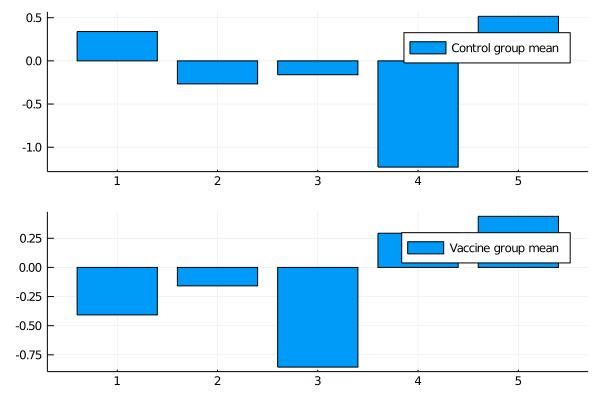

In [31]:
# Plotting the distribution
l = @layout [a ; b]
p1 = bar(collect(1:n_traits), mean(data[ctrl_idxs, :], dims=1)', label = "Control group mean")
p2 = bar(collect(1:n_traits), mean(data[vacc_idxs, :], dims=1)', label = "Vaccine group mean")
plot(p1, p2, layout = l)


### Can Optimization do better? 
It sure can! Let's start by writing out the problem. 

In this case, we will pick 2 groups of equal numbers of patients from the population, while minimizing the absolute value of the error in the mean and variances between the two groups. 

In [7]:
# Let's start creating out model, and trying to solve without uncertainty
m = Model(solver=GurobiSolver())
@variable(m, x[i=1:n_people, 1:n_groups], Bin)
@variable(m, μ_p[i=1:n_groups, j=1:n_traits]) # Mean
@variable(m, σ_p[i=1:n_groups, j=1:n_traits]) # Variance
for j = 1:n_groups # Taking the mean and std deviation of parameters for each group
    @constraint(m, μ_p[j,:] .== 1/(n_patients/n_groups) * 
                    sum(data[i,:].*x[i,j] for i=1:n_people))
    @constraint(m, σ_p[j,:] .== 1/(n_patients/n_groups) * 
                    sum(data[i,:].^2 .* x[i,j] for i=1:n_people))
    @constraint(m, sum(x[:,j]) == n_patients/n_groups)
end
for i = 1:n_people
    @constraint(m, sum(x[i, :]) <= 1)
end

@variable(m, d)
@variable(m, M[1, 1:n_traits])
@variable(m, V[1, 1:n_traits])
rho = 0.5
@objective(m, Min, sum(M) + rho*sum(V))
for i = 1:n_groups
    for j = i+1:n_groups
        @constraint(m, M[1, :] .>= μ_p[i,:] - μ_p[j,:])
        @constraint(m, M[1, :] .>= μ_p[j,:] - μ_p[i,:])
        @constraint(m, V[1, :] .>= σ_p[i, :] - σ_p[j, :])
        @constraint(m, V[1, :] .>= σ_p[j, :] - σ_p[i, :])
    end
end

In [8]:
solve(m)

Academic license - for non-commercial use only
Optimize a model with 62 rows, 71 columns and 560 nonzeros
Variable types: 31 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 4.0024781
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s
Presolved: 62 rows, 70 columns, 548 nonzeros
Variable types: 30 continuous, 40 integer (40 binary)

Root relaxation: objective 0.000000e+00, 55 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   12    4.00248    0.00000   100%     -    0s
H    0     0                       1.9054940    0.00000   100%     -    0s
H    0     0                       1.7309744    0.00000   100%     -    0s
     0     0    0.00000    0 

:Optimal

In [9]:
# Let's see the results
ctrl_opt = findall(x -> x == 1, Array(getvalue.(x[:,1])))
vacc_opt = findall(x -> x == 1, Array(getvalue.(x[:,2])))
println("Control group: ", ctrl_opt)
println("Vaccine group: ", vacc_opt)
println("Mean traits of control group: ", getvalue(μ_p[1,:]))
println("Mean traits of vaccine group: ", getvalue(μ_p[2,:]))
println("Variance of traits of control group: ", getvalue(σ_p[1,:]))
println("Variance of traits of vaccine group: ", getvalue(σ_p[2,:]))


Control group: [1, 7, 11, 12, 16]
Vaccine group: [2, 3, 14, 18, 19]
Mean traits of control group: [0.106356, 0.252982, -0.095017, -0.330417, -0.0760185]
Mean traits of vaccine group: [0.208953, 0.186022, 0.0925075, -0.383939, -0.0894256]
Variance of traits of control group: [0.384978, 0.940419, 0.797375, 1.87592, 0.380005]
Variance of traits of vaccine group: [0.430702, 0.91851, 0.988913, 1.98738, 0.443228]


In [10]:
# In comparison, here are the randomization results again. 
ctrl_idxs = Int64.(collect(1:n_patients/2))
vacc_idxs = Int64.(collect(n_patients/2+1:n_patients))
println("Control group: ", ctrl_idxs)
println("Vaccine group: ", vacc_idxs)
println("Mean traits of control group: ", mean(data[ctrl_idxs, :], dims=1))
println("Mean traits of vaccine group: ", mean(data[vacc_idxs, :], dims=1))
println("Variance of traits of control group: ", var(data[ctrl_idxs, :], dims=1))
println("Variance of traits of vaccine group: ", var(data[vacc_idxs, :], dims=1))

Control group: [1, 2, 3, 4, 5]
Vaccine group: [6, 7, 8, 9, 10]
Mean traits of control group: [0.339804 -0.266668 -0.160643 -1.23033 0.515767]
Mean traits of vaccine group: [-0.407521 -0.158313 -0.855196 0.293271 0.438168]
Variance of traits of control group: [0.77972 1.27865 1.47524 1.134 1.16889]
Variance of traits of vaccine group: [1.92856 1.68381 2.84739 0.4778 1.42322]


#### Important note: We are not limited to this objective function!
For example, we could try maximizing variance while keeping the mean variation below a threshold... you can try any combination that is bounded from below!

### How does Robust Optimization (RO) change our solutions? 
It sure can! Let's start by writing out the problem. 

In [33]:
# Let's start creating out model, and trying to solve with uncertainty
rm = RobustModel(solver=GurobiSolver())
# @variable(rm, Γ)
Γ = 2
# Let's start creating out model, and trying to solve without uncertainty
@variable(rm, x[i=1:n_people, 1:n_groups], Bin)
@variable(rm, μ_p[i=1:n_groups, j=1:n_traits]) # Mean
@variable(rm, σ_p[i=1:n_groups, j=1:n_traits]) # Variance
@uncertain(rm, ell[1:n_people, 1:n_traits])
@constraint(rm, norm(ell, 2) <= Γ)
for j = 1:n_groups # Taking the mean and std deviation of parameters for each group
    @constraint(rm, μ_p[j,:] .== 1/(n_patients/n_groups) * 
                    sum(data[i,:].*x[i,j] for i=1:n_people))
    @constraint(rm, σ_p[j,:] .== 1/(n_patients/n_groups) * 
                    sum(data[i,:].^2 .* x[i,j] for i=1:n_people))
    @constraint(rm, sum(x[:,j]) == n_patients/n_groups)
end
for i = 1:n_people
    @constraint(rm, sum(x[i, :]) <= 1)
end

@variable(rm, d)
@variable(rm, M[1, 1:n_traits])
@variable(rm, V[1, 1:n_traits])
rho = 0.5
@objective(rm, Min, sum(M) + rho*sum(V))
for i = 1:n_groups
    for j = i+1:n_groups
        for l = 1:n_traits
            @constraint(rm, M[1, l] >= 1/(n_patients/n_groups) * 
                        sum((data[k,l] + ell[k,l]) .* (x[k,j] - x[k,i]) for k=1:n_people))
            @constraint(rm, M[1, l] >= - 1/(n_patients/n_groups) * 
                        sum((data[k,l] + ell[k,l]) .* (x[k,j] - x[k,i]) for k=1:n_people))
            # Sometimes you have to get creative... linearization of the change of the variance. 
            @constraint(rm, V[1, l] >= 1/(n_patients/n_groups) * 
                        sum((data[k,l].^2 + 2*data[k,l]*ell[k,l]) .* (x[k,j] - x[k,i]) for k=1:n_people))
            @constraint(rm, V[1, l] >= - 1/(n_patients/n_groups) * 
                        sum((data[k,l].^2 + 2*data[k,l]*ell[k,l]) .* (x[k,j] - x[k,i]) for k=1:n_people))
        end
    end
end

In [34]:
solve(rm)

Academic license - for non-commercial use only
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 2062 rows, 2091 columns and 4140 nonzeros
Model has 20 quadratic constraints
Variable types: 2051 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [2e-05, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Solve qcp for cone disaggregation ...
Presolve removed 1990 rows and 1990 columns
Presolve time: 0.03s
Presolved: 92 rows, 501 columns, 1576 nonzeros
Variable types: 461 continuous, 40 integer (40 binary)

Root relaxation: objective 0.000000e+00, 58 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   12          -    0.00000      -     -    0s
     0     0    0.00000 

:Optimal

In [35]:
# Let's see the results
ctrl_ro = findall(x -> x == 1, Array(getvalue.(x[:,1])))
vacc_ro = findall(x -> x == 1, Array(getvalue.(x[:,2])))
println("Control group: ", ctrl_ro)
println("Vaccine group: ", vacc_ro)
println("Mean traits of control group: ", getvalue(μ_p[1,:]))
println("Mean traits of vaccine group: ", getvalue(μ_p[2,:]))
println("Variance of traits of control group: ", getvalue(σ_p[1,:]))
println("Variance of traits of vaccine group: ", getvalue(σ_p[2,:]))

Control group: [1, 5, 6, 13, 17]
Vaccine group: [7, 11, 14, 18, 19]
Mean traits of control group: [0.541184, 0.643909, -0.517373, 0.0100292, 0.230661]
Mean traits of vaccine group: [0.433284, 0.657382, -0.525811, 0.164979, -0.024437]
Variance of traits of control group: [0.961526, 0.831195, 0.86583, 0.57622, 0.45842]
Variance of traits of vaccine group: [0.479332, 0.729259, 0.962119, 0.794172, 0.426578]


In [ ]:
# Compare to optimal results